# Figures from "A Global Gridded Dataset for Cloud Vertical Structure from combined CloudSat and CALIPSO observations" in Earth System Science Data 2023
Extract ESSD_figs_files.zip in same directory as notebook to run cells

In [99]:
import os
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs         # import projections
import cartopy.feature as cf       # import features
#from cloudsat_util_07 import *
from glob import glob
from cmcrameri import cm as cmc    # nice colorbars
from cmocean import cm as cmo      # nice colorbars

import json                        # for reading in doop-spline data
from scipy import interpolate      # for evaluating splines
import matplotlib.dates as mdates  # month locator
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # month locator
from matplotlib.ticker import FixedLocator # set tick labels manually without a warning
import matplotlib.colors as mcolors #for norms

# figure 1: combined cloud mask quicklook

In [2]:
ds = xr.open_dataset('./essd_figs_files/8-9_granule23108_combined_mask.nc')
ds['Profile_time'].attrs['units'] = 's'
ds['Profile_time'].data = ds.Profile_time.values.astype(float)/1e9

/var/folders/d7/pzx111116r734nzj6lx4k3wh0000gp/T/ipykernel_24764/824489516.py:5: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = plt.pcolormesh(ds.Profile_time, ds.Height.T/1e3, ds.combined_vis.T,shading='nearest',alpha=0.8,edgecolors=None,cmap=cmap,rasterized=True)
/var/folders/d7/pzx111116r734nzj6lx4k3wh0000gp/T/ipykernel_24764/824489516.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  secax.set_xticklabels(pos_xticks);


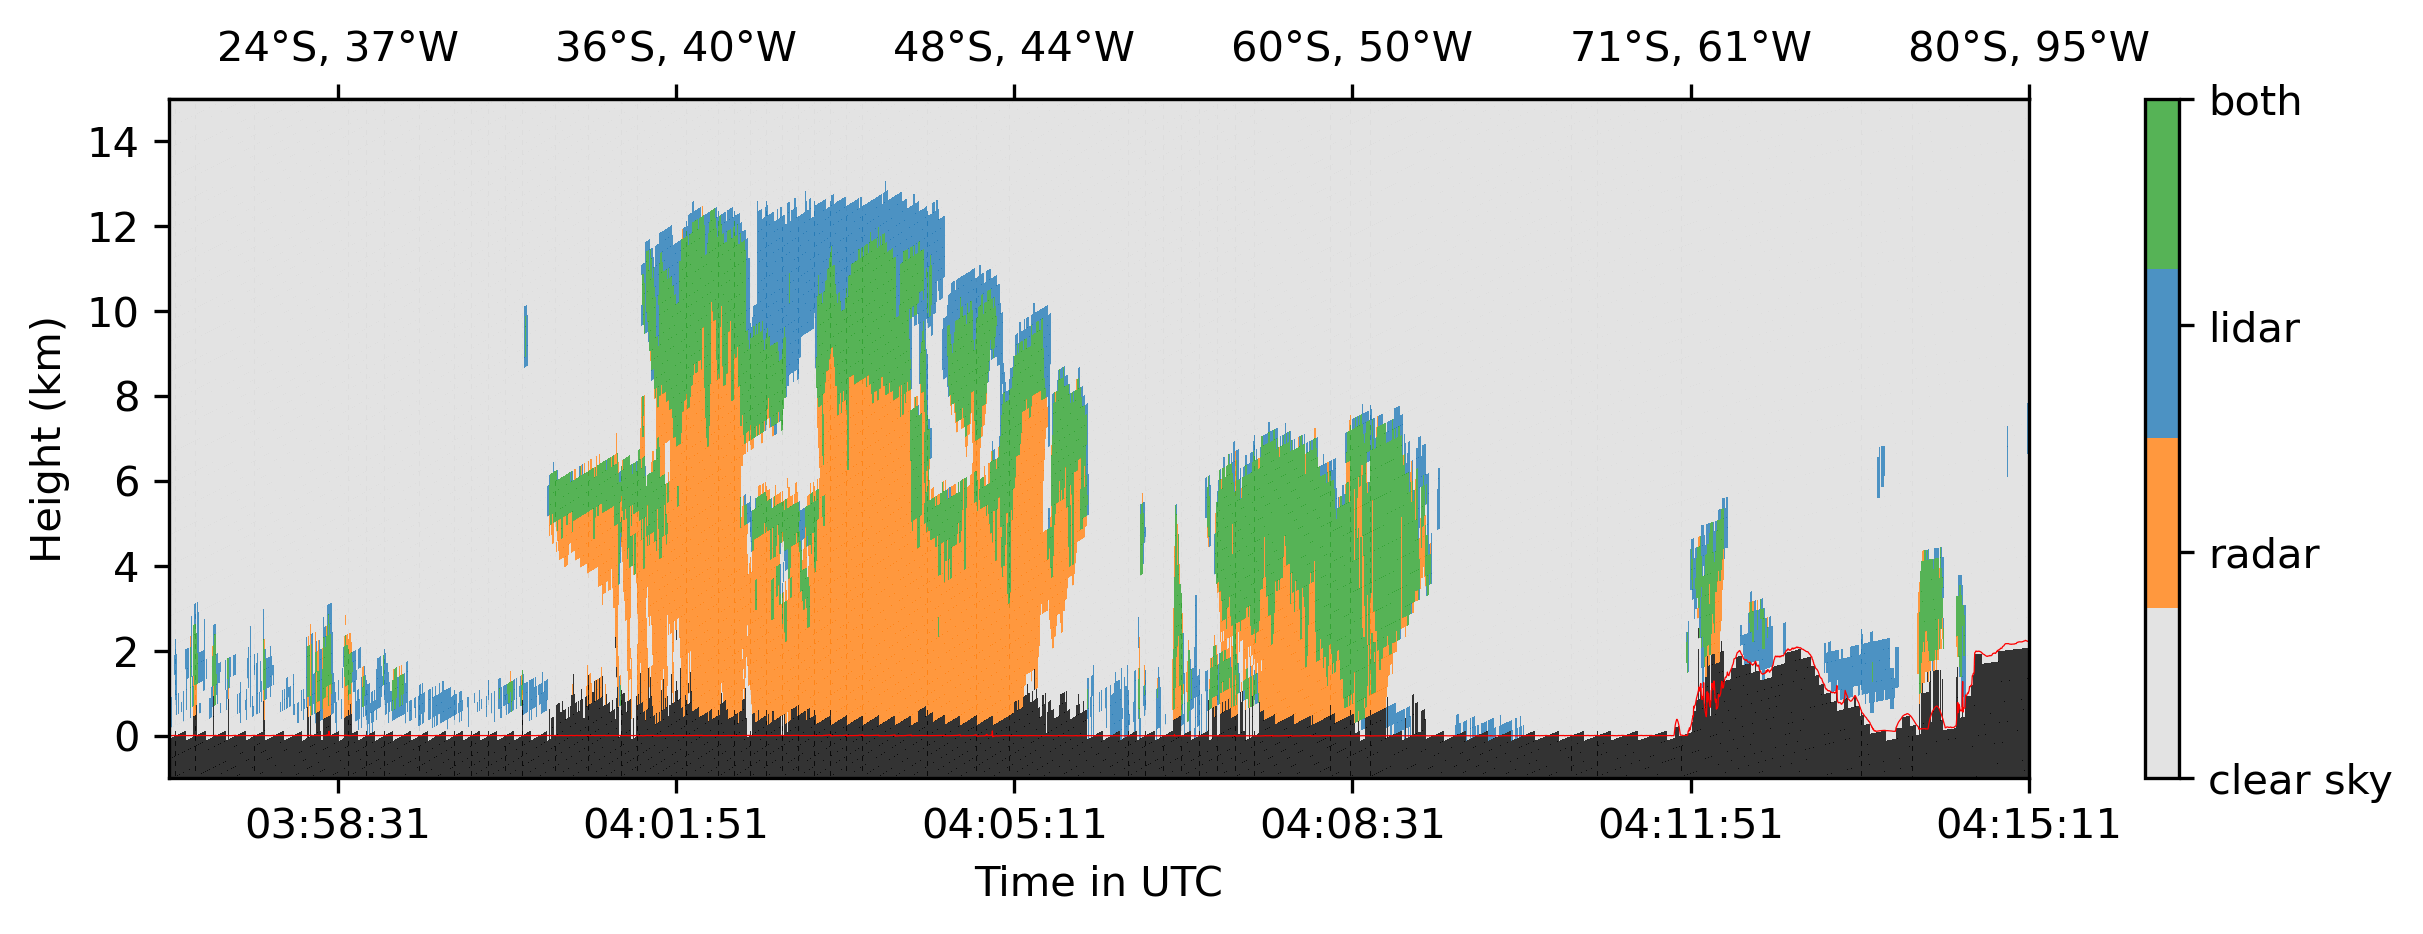

In [3]:
plt.figure(figsize=(10,3),dpi=300)
cmap = mpl.colors.ListedColormap(['rosybrown','gainsboro','tab:orange','tab:blue','tab:green'])
cmap = mpl.colors.ListedColormap(['gainsboro','tab:orange','tab:blue','tab:green'])
cmap.set_bad('black')
im = plt.pcolormesh(ds.Profile_time, ds.Height.T/1e3, ds.combined_vis.T,shading='nearest',alpha=0.8,edgecolors=None,cmap=cmap,rasterized=True)
cb = plt.colorbar(im)
plt.ylim(-1,15)
shb_ht   = ds.Height.data[np.arange(ds.dims['profile']),ds.SurfaceHeightBin.data.astype(int)-1]
shb_corr = -ds.SurfaceHeightBin_fraction.where(ds.SurfaceHeightBin_fraction>-1,0)*ds.Vertical_binsize
surf_clutter = shb_ht+shb_corr
plt.plot(ds.Profile_time,surf_clutter/1e3,c='r',lw=0.3)
#plt.xlim(3600,4600)
plt.xlim(300,1400)
plt.ylabel('Height (km)')
plt.xlabel('Time in UTC')
cb.set_ticks(np.linspace(0,3,4))
cb.set_ticklabels(['clear sky','radar','lidar','both'])

#set formatted time ticks
dts = pd.to_datetime(plt.gca().get_xticks(),unit='s',origin=ds.start_time.values)
time_xticks = dts.strftime('%H:%M:%S')
plt.gca().xaxis.set_major_locator(FixedLocator(plt.gca().get_xticks()))
plt.gca().set_xticklabels(time_xticks);

#add a secondary x-axis, make it the same as the primary x-axis so ticks align
secax = plt.gca().secondary_xaxis('top', functions=(lambda x: x, lambda x: x))
#secax.set_xlabel('position')

#print out lat,lon for each profile time tick
pos_xticks = [ ]
for time in plt.gca().get_xticks():
    i = np.argmin(np.abs(ds.Profile_time.values-time))
    lat = ds.Latitude.isel(profile=i).values
    lon = ds.Longitude.isel(profile=i).values
    ns  = 'N' if lat>0 else 'S'
    ew  = 'E' if lat>0 else 'W'
    tick = f'{np.abs(lat):.0f}°{ns}, {np.abs(lon):.0f}°{ew}'
    pos_xticks.append(tick)

#secax.xaxis.set_major_locator(FixedLocator(secax.get_xticks()))
secax.set_xticklabels(pos_xticks);

#ax2.set_xticks(np.arange(0,20))
plt.savefig('mask_quicklook_jun20.pdf',facecolor='white',transparent=False,bbox_inches='tight')
#plt.title('quicklook with new proc_and_mask')

# figure 2: CloudSat vs. CALIOP L3 product zonal-mean occurrence

In [8]:
cal = xr.open_dataset('./essd_figs_files/8-7-2_2006-2011_averaged_calipso_cloud_fraction.nc')
cs = xr.open_dataset('./essd_figs_files/8-9_2006-2011_averaged_cloudsat_cloud_fraction.nc')

cal_months, cs_months = cal.time, cs.time
cal, cs = cal.mean(dim='time'),cs.mean(dim='time')

<xarray.DataArray 'zonal_mean_cloud_fraction' ()>
array(0.48610866)
<xarray.DataArray 'zonal_mean_attenuation_fraction' ()>
array(0.66313541)
<xarray.DataArray 'zonal_meal_cloud_fraction' ()>
array(0.52913076)
Coordinates:
    cclass_s  |S100 b'All cases'
    doop_s    |S100 b'All cases'
    precip_s  |S100 b'All cases'


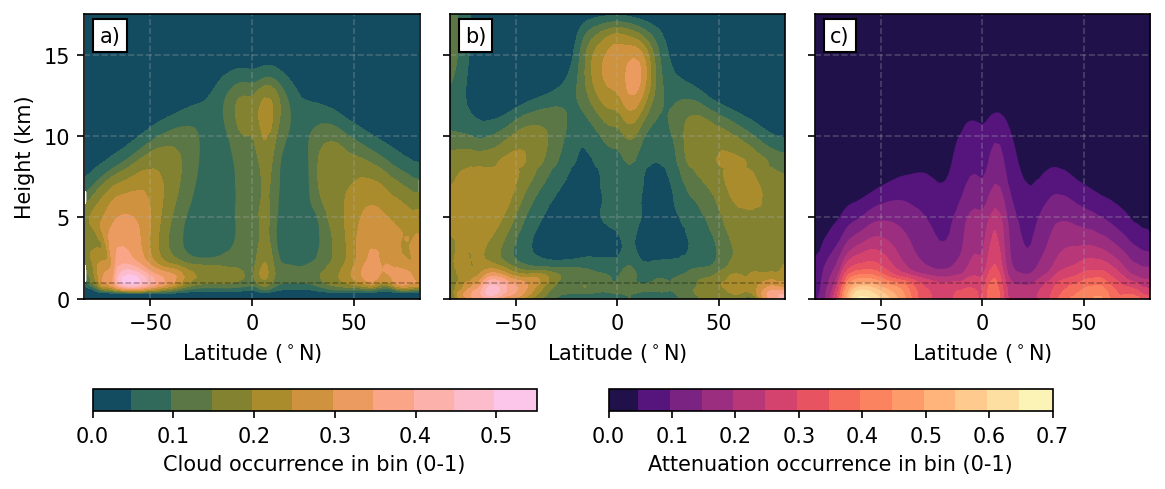

In [132]:
fig,axes = plt.subplots(1,3,dpi=150,figsize=(8,3),sharex=True,sharey=True)
cldlvs = np.arange(0,0.6,0.05)
#norm=mcolors.PowerNorm(gamma=0.8,vmin=0.025,vmax=0.575) #get 0 as darkest color (jump)

#use a power-law color map norm to keep the darker colors from dominating the figure
norm = lambda vmin,vmax: mcolors.PowerNorm(gamma=0.6,vmin=vmin,vmax=vmax)
#subplot 2
vcf = cal['zonal_mean_cloud_fraction']
print(np.max(vcf))
im = axes[1].contourf(vcf.Latitude_Midpoint,vcf.Altitude_Midpoint,vcf.T,levels=10,cmap=cmc.batlow,
                      norm=norm(0,0.55))
axes[1].text(-75,15.8, 'b)', #style='bold',
        bbox={'facecolor': 'white', 'alpha': 1, 'pad': 3})
for c in im.collections: #fix PDF white line aliasing
    c.set_edgecolor("face")

#subplot 3
vcf = cal['zonal_mean_attenuation_fraction']
alt = cal.Altitude_Midpoint
print(np.max(vcf))
im2 = axes[2].contourf(vcf.Latitude_Midpoint,alt,vcf.T,levels=np.arange(0,0.75,0.05),cmap='magma',
                      norm=norm(0,0.7))
axes[2].text(-75,15.8, 'c)', #style='bold',
        bbox={'facecolor': 'white', 'alpha': 1, 'pad': 3})
for c in im2.collections: #fix PDF white line aliasing
    c.set_edgecolor("face")

#subplot 1
vcf = cs.zonal_meal_cloud_fraction
print(np.max(vcf))
im = axes[0].contourf(vcf.Latitude,vcf.Height/1e3,vcf.T,levels=10,cmap=cmc.batlow,norm=norm(0,0.55))
axes[0].text(-75,15.8, 'a)', #style='bold',
        bbox={'facecolor': 'white', 'alpha': 1, 'pad': 3})
axes[0].set_ylim(0,17.5)
axes[0].set_xlim(-82.5,82.5)
axes[0].set_ylabel('Height (km)')
for c in im.collections: #fix PDF white line aliasing
    c.set_edgecolor("face")
[ax.grid(which='both',alpha=0.3,ls='--') for ax in axes]
[ax.set_xlabel(r'Latitude ($^\circ{\mathrm{N}}$)') for ax in axes]
fig.tight_layout()

#add hlines at 1 km
[ax.axhline(0.960,ls='--',c='k',alpha=0.3,lw=0.75) for ax in axes]

#add colorbars
fig.subplots_adjust(bottom=0.3)
cbar_ax0 = fig.add_axes([0.1, 0.05, 0.37, 0.05])
cb = fig.colorbar(im, cax=cbar_ax0,orientation='horizontal')
cb.solids.set_edgecolor("face") #get rid of white lines between levels in PDF
cb.set_label('Cloud occurrence in bin (0-1)')
cbar_ax1 = fig.add_axes([0.53, 0.05, 0.37, 0.05])
cb = fig.colorbar(im2, cax=cbar_ax1,orientation='horizontal')
cb.solids.set_edgecolor("face") #get rid of white lines between levels in PDF
cb.set_label('Attenuation occurrence in bin (0-1)')
#ax.set_title('Vertical Zonal Cloud Fraction')
#ax.set_xlabel(r'latitude ($^\circ$N)')
fig.savefig('9-4-2_rmcp_cal3d_zonalmean_2007_withattenuation_newcolor.pdf',facecolor='white',transparent=False,bbox_inches='tight')

# fig. 4: illustration of DO-Op sampling

In [6]:
def read_spline(filename='doop_spldict.json',keys=('knot_pos','bspl_coeff','deg')):
    '''read json dict of t,c,k values back to tck tuples
    for use in scipy.interpolate.splXXX routines.
    Note: routine assumes dict has two splines:
    'first_doop_profile' and 'last_doop_profile'
    '''
    #read json dict of structure {spline1:{t:,c:,k:},spline2:{t:,c:,k:}
    #convert to {spline1:tck,spline2:tck} tuple of arrays
    with open(filename) as f:
        rspl = json.loads(f.read())
    #convert the 2nd level of keys (knotpos, coeff, deg) to tuple of arrays (tck)
    rspl = dict([(d,[np.asarray(rspl[d][key]) for key in keys]) for d in rspl])
    #note that splder CHANGES spline degree if k is of type np.array and not int
    #so we have to manually change that
    for d in rspl:
        rspl[d][2] = int(rspl[d][2])
    return rspl['first_doop_profile'],rspl['last_doop_profile']

In [7]:
tck_fi,tck_la = read_spline(filename='doop_spldict.json')

In [8]:
dates = pd.date_range('01-01-2001','12-31-2001')
tt = dates.dayofyear

In [9]:
def plot_jump(lat,lon,label=None,ax=None,line_kws={}):
    ''' Plot data which wraps around the axis
        by splitting into multiple plot calls
        (to avoid the artifical lines across the axes)
    '''
    if ax==None: ax = plt.gca()
    jumps = np.where(np.diff(lat)>0)[0]
    jump = jumps[0]
    plt.plot(lat[:jump+1],lon[:jump+1],label=label,**line_kws)
    plt.plot(lat[jump+1:],lon[jump+1:],**line_kws)

In [10]:
dec = xr.open_dataset('./essd_figs_files/8-9_example_doop_track_dec.nc')
jun = xr.open_dataset('./essd_figs_files/8-9_example_doop_track_jun.nc')

Text(-173, 60, 'c)')

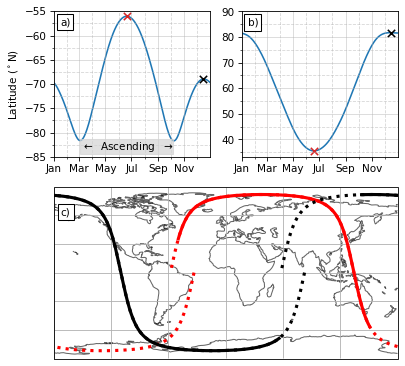

In [11]:
#gridspec stuff
fig = plt.figure(dpi=75,figsize=(5.5,5))
gs = fig.add_gridspec(2, 2, height_ratios=(1,1.2))  #,width_ratios=(7, 2), height_ratios=(2, 7),
                      #left=0.1, right=0.9, bottom=0.18, top=0.87,
                      #wspace=0.05, hspace=0.05)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[1,:],projection=ccrs.PlateCarree())

#firsts plot
dates = pd.date_range('01-01-2001','12-31-2001')
tt = dates.dayofyear
ax = ax0
ax.plot(dates,interpolate.splev(tt,tck_fi,der=0),label='First profile',zorder=-100)
dmax = pd.to_datetime('06-20-2001')
ax.scatter(dmax,interpolate.splev(dmax.dayofyear,tck_fi,der=0),marker='x',s=50,c='tab:red')
dmin = pd.to_datetime('12-15-2001')
ax.scatter(dmin,interpolate.splev(dmin.dayofyear,tck_fi,der=0),marker='x',s=50,c='k')
#plt.axvline(63,c='k',ls='--')
#plt.axvline(281,c='k',ls='--')
#plt.axhline(-81.8,c='b',ls='--')
ax.xaxis.set_major_locator(mdates.MonthLocator(range(1,13,2)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.yaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(2.5))
ax.set_xlim(pd.to_datetime('2001-01-01'),pd.to_datetime('2001-12-31'))
ax.grid(which='major',alpha=0.5)
ax.grid(which='minor',alpha=0.5,ls='--')
ax.set_ylabel(r'Latitude $(^\circ{\mathrm{N}}$)')
ax.set_ylim(-85,-55)
ax.text(pd.to_datetime('2001-03-04'),-83.5, r'$\leftarrow$  Ascending  $\rightarrow$', #style='bold',
        bbox={'facecolor': 'lightgrey', 'alpha': 0.7, 'pad': 0.5,'edgecolor':'lightgrey'},color='black')


ax=ax1
ax.plot(dates,interpolate.splev(tt,tck_la,der=0),label='Last profile',zorder=-100)
dmax = pd.to_datetime('06-20-2001')
ax.scatter(dmax,interpolate.splev(dmax.dayofyear,tck_la,der=0),marker='x',s=50,c='tab:red')
dmin = pd.to_datetime('12-15-2001')
ax.scatter(dmin,interpolate.splev(dmin.dayofyear,tck_la,der=0),marker='x',s=50,c='k')
ax.xaxis.set_major_locator(mdates.MonthLocator(range(1,13,2)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.set_xlim(pd.to_datetime('2001-01-01'),pd.to_datetime('2001-12-31'))
#ax.set_ylabel(r'Latitude $(^\circ{\mathrm{N}}$)')
ax.grid(which='major',alpha=0.5)
ax.grid(which='minor',alpha=0.5,ls='--')
ax.set_ylim(ymax=90)

ax=ax2
ax.gridlines()
ax.coastlines(alpha=0.6)

for ds_day, c in zip((jun,dec),('r','k')):
    for argmap,ls in zip((ds_day.doop_flag,~ds_day.doop_flag),('-',':')):
        kws = {'lw':3,'ls':ls,'color':c}
        g = ds_day.where(argmap,np.nan)
        try:
            plot_jump(g.lon,g.lat,line_kws=kws,ax=ax)
        except IndexError:
            ax.plot(g.lon,g.lat,**kws)

fig.tight_layout()

ax0.text(pd.to_datetime('2001-01-15'),-57.8, 'a)', #style='bold',
        bbox={'facecolor': 'white', 'alpha': 1, 'pad': 3})
ax1.text(pd.to_datetime('2001-01-15'),84.5, 'b)', #style='bold',
        bbox={'facecolor': 'white', 'alpha': 1, 'pad': 3})
ax2.text(-173,60, 'c)', #style='bold',
        bbox={'facecolor': 'white', 'alpha': 1, 'pad': 3})
#fig.savefig('8-9_doop_spline_withdemo.pdf',facecolor='white',transparent=False,bbox_inches='tight')

# fig 5: whole-mission sampling plot

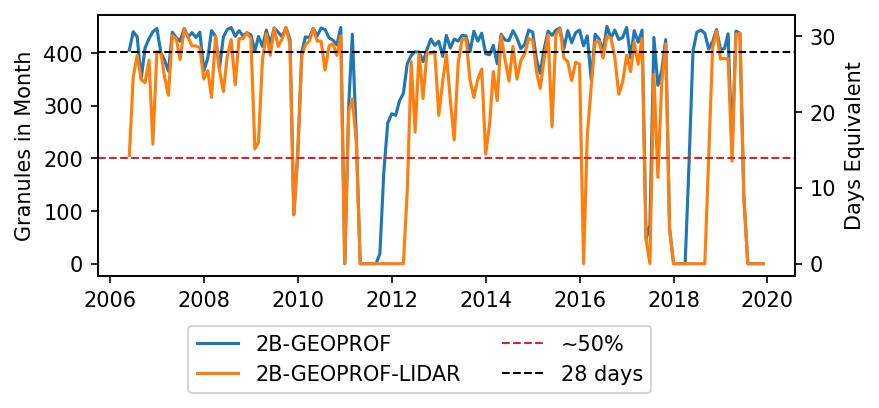

In [12]:
fig,ax = plt.subplots(1,1,dpi=150,figsize=(6,3))
df = pd.read_csv('./essd_figs_files/8-9-1_input_data_availability.csv')
mons = pd.to_datetime(df.time)
radar_n = df['number of radar granules']
lidar_n = df['number of lidar granules']
ax.plot(mons,radar_n,label='2B-GEOPROF')
ax.plot(mons,lidar_n,label='2B-GEOPROF-LIDAR')
#plt.plot(mons,both_n,label='both')
ax.axhline(200,c='tab:red',lw=1,ls='--',label='~50%')
ax.axhline(28*24*60/1e2,c='k',lw=1,ls='--',label='28 days')
#[plt.axvline(time,c='k',ls=':') for time in epochs.values()]
ax2 = ax.twinx()
ax2.set_ylim([x*100/24/60 for x in ax.get_ylim()])
ax2.set_ylabel('Days Equivalent')

ax.legend(loc=(0.13,-0.45),ncol=2)
ax.set_ylabel('Granules in Month')
fig.subplots_adjust(bottom=0.3)
#plt.savefig('datacoverage_paperformat_incl2019.pdf',facecolor='white',transparent=False)

# fig 6: overview comparable to fig. 2

In [116]:
cscal = xr.open_dataset('./essd_figs_files/8-9_3gc_2006-2019_cloudcover_zonalmean_cloudfraction.nc')

#note: 3S-GEOPROF-COMB-beta_v7.2.1 has a few observations north of 82.5 N and below sea level in the Arctic.
#we clip the range of the average to remove these regions where cloud fraction is defined but not significant.
da = cscal['vertical_cloud_fraction']
da = da.where(da.height>-240) #set sub-mean sea level bins to NaN
da = da.where(np.abs(da.lat)<82.5) #set obs outside normal observing range to NaN
cscal['vertical_cloud_fraction'] = da

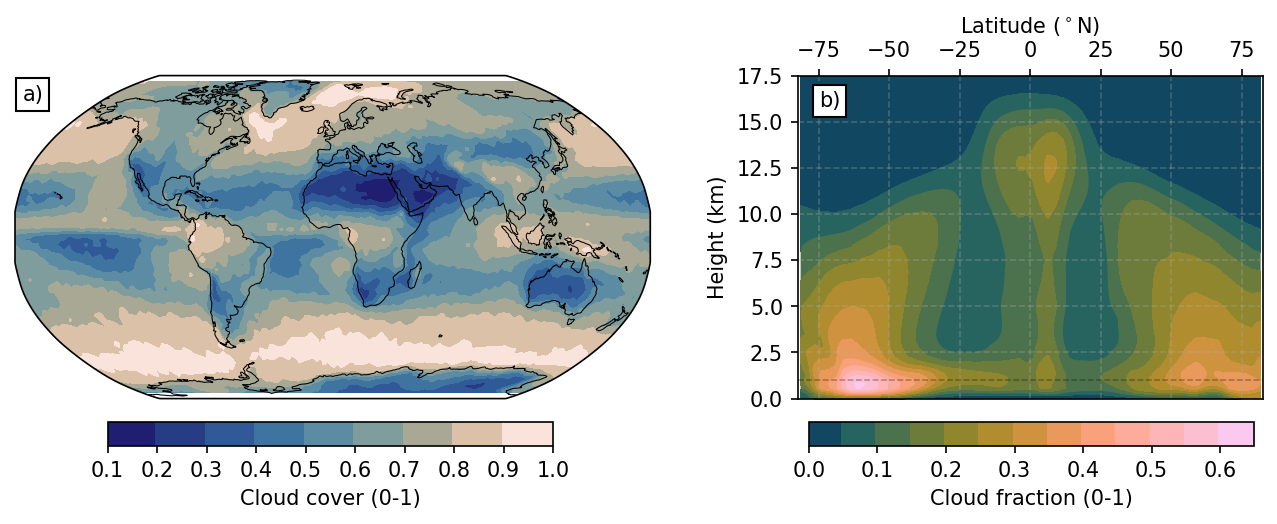

In [122]:
nrow,ncol = 1,2
fig  = plt.figure(figsize=(11,11/3-0.5),dpi=150)
gs   = fig.add_gridspec(nrow, ncol, width_ratios=[0.6,0.4])
#first subplot is robinson projection, second subplot no projection
axes = [fig.add_subplot(gs[0],projection=ccrs.Robinson(central_longitude=0)), fig.add_subplot(gs[1])]

#cloud cover map
cmap=cmc.lapaz #turbo_r, Blues_r, GnBu_r, Greys, bone
im = axes[0].contourf(cscal.cloud_cover, 
               origin='lower', extent=[-180,180,-90,90],
               transform=ccrs.PlateCarree(), cmap=cmap,levels=np.linspace(0.1,1,10))
cbar_ax = fig.add_axes([0.2, 0.1, 0.27, 0.05])
cb = fig.colorbar(im, cax=cbar_ax,orientation='horizontal')
cb.solids.set_edgecolor("face") #get rid of white lines between levels in PDF
cb.set_label('Cloud cover (0-1)')
axes[0].add_feature(cf.COASTLINE,lw=0.5)
axes[0].text(-1.65e7,0.725e7, 'a)', #style='bold',
        bbox={'facecolor': 'white', 'alpha': 1, 'pad': 3})
for c in im.collections: #fix PDF white line aliasing (https://stackoverflow.com/questions/15822159/aliasing-when-saving-matplotlib-filled-contour-plot-to-pdf-or-eps)
    c.set_edgecolor("face")

#zonal-mean cloud fraction
#use the power-law color map norm from fig 2 to keep the darker colors from dominating the figure
vcf = cscal.vertical_cloud_fraction
im = axes[1].contourf(vcf.lat,vcf.height/1e3,vcf.T,levels=np.arange(0.,0.7,0.05),cmap=cmc.batlow, norm=norm(0,0.65)) #turbo
axes[1].xaxis.tick_top()  
axes[1].xaxis.set_label_position('top') 
axes[1].set_ylabel('Height (km)')
fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.625, 0.1, 0.27, 0.05])
cb = fig.colorbar(im, cax=cbar_ax,orientation='horizontal')
cb.solids.set_edgecolor("face") #get rid of white lines between levels in PDF
cb.set_label('Cloud fraction (0-1)')#for ht in da.height:
#axes[1].set_title('Vertical Zonal Cloud Fraction')
axes[1].set_xlabel(r'latitude ($^\circ$N)')
axes[1].set_ylim(0,17.5)
axes[1].set_xlim(-82.5,82.5)
axes[1].grid(which='both',alpha=0.3,ls='--')
axes[1].set_xlabel(r'Latitude ($^\circ{\mathrm{N}}$)')
axes[1].axhline(1,ls='--',c='k',alpha=0.3,lw=0.75)
axes[1].text(-75,15.8, 'b)', #style='bold',
        bbox={'facecolor': 'white', 'alpha': 1, 'pad': 3})
for c in im.collections: #fix PDF white line aliasing (https://stackoverflow.com/questions/15822159/aliasing-when-saving-matplotlib-filled-contour-plot-to-pdf-or-eps)
    c.set_edgecolor("face")
fig.savefig('9-4-2_exampleplots_newcolor.pdf',facecolor='white',transparent=False,bbox_inches='tight')

# fig 7: effects of DO-Op and grid size on statistics

In [15]:
sampling = {dx:xr.open_dataset(f'./essd_figs_files/8-9_JulDec_v7.2_sampling_g{dx:.1f}.nc') for dx in [1,2.5,5,10]}

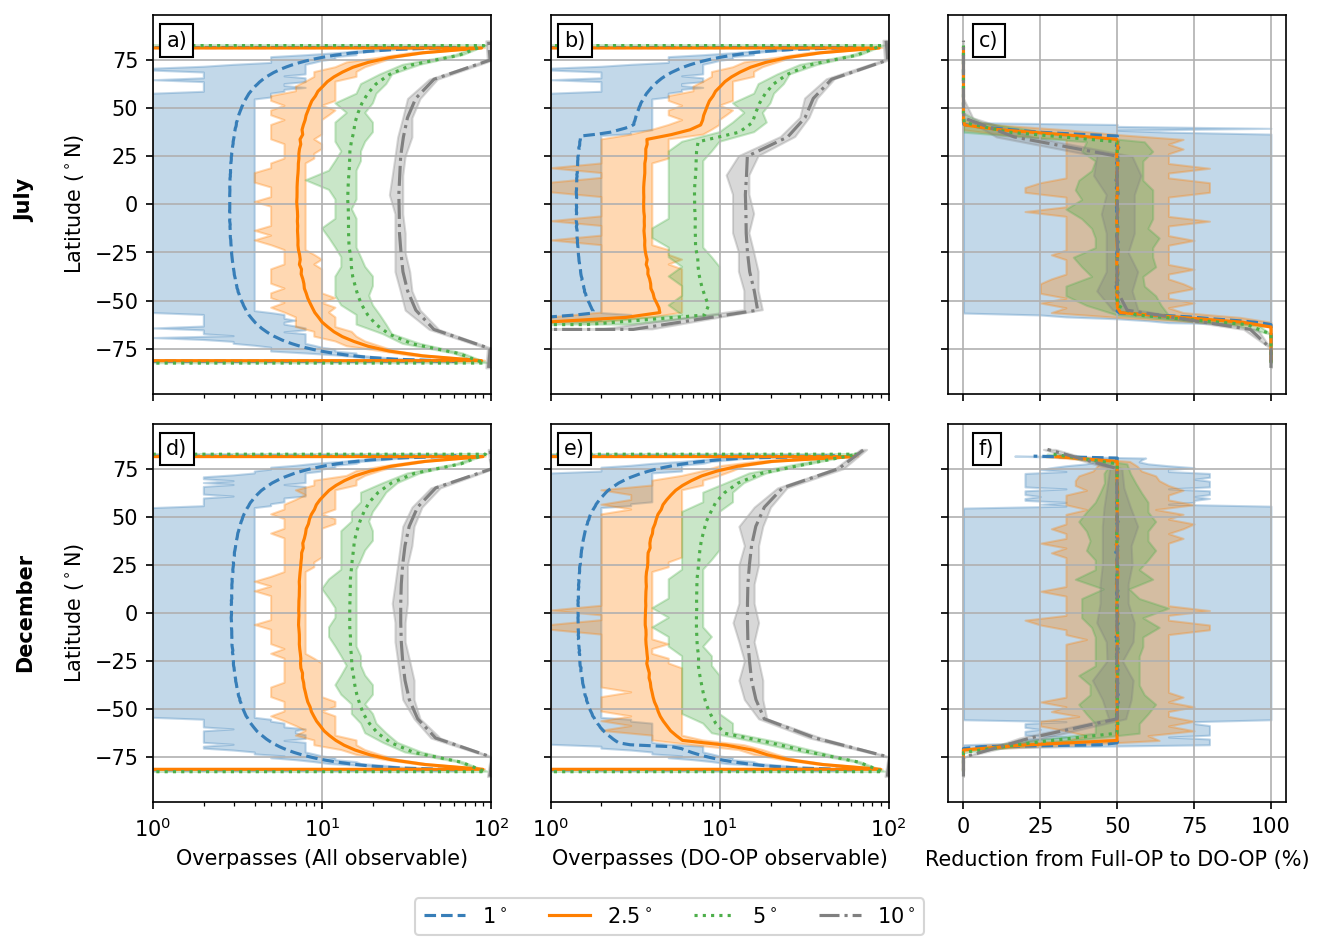

In [16]:
#first build a figure showing the zonal variations in sampling are reduced with increasing grid size
fig, axes = plt.subplots(2,3,dpi=150,figsize=(8.5,6),sharex='col',sharey=True)
states = (b'All cases',b'DO-OP observable',b'Reduction')
var = 'n_overpasses'
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  'grey', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
#colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c']
colors = CB_color_cycle[:4]
lses = ('--','-',':','-.')
letters = iter([f'{s})' for s in 'abcdef']) 

#colors = CB_color_cycle[:4]
for row,mon in zip(axes,[6,11]): #july,dec (0-indexed)
    for ax, state in zip(row,states):
        for color,ls,(res,ds) in zip(colors,lses,sampling.items()):
            ds = ds.sel(time=ds['time.month']==mon+1) #select month of interest
            ds = ds.squeeze('time') #remove dimension of size 1
            lower = ds[var].sel(doop=state).min(dim='lon')
            upper = ds[var].sel(doop=state).max(dim='lon')
            mean  = ds[var].sel(doop=state).mean(dim='lon')
            ax.plot(mean,ds.lat,label=f'{res}$^\circ$',color=color,ls=ls)
            ax.fill_betweenx(ds.lat,lower,upper,alpha=0.3,color=color,label=None)
            #do axes things
            if ax in axes[-1]: 
                if state == b'All cases': #kludgey rename per Jen's suggestion
                    ax.set_xlabel(f'Overpasses (All observable)')
                else:
                    ax.set_xlabel(f'Overpasses ({state.decode()})')
            if ax == axes[-1][-1]: ax.set_xlabel('Reduction from Full-OP to DO-OP (%)')
            if ax in axes[:,0]: ax.set_ylabel('Latitude ($^\circ$N)')
            if ax not in axes[:,-1]: 
                ax.semilogx()
                ax.set_xlim(1,100)
        #ax.set_xticks(np.arange(0,30,5),minor=True)
        ax.text(5 if ax in axes[:,-1] else 1.2,82,next(letters), bbox={'facecolor': 'white', 'alpha': 1, 'pad': 3})
        ax.grid(which='major')
fig.tight_layout()
# axes[-1].set_xlim(-5,105)
# [ax.text(x,86, s, bbox={'facecolor': 'white', 'alpha': 1, 'pad': 3}) for ax,x,s in zip(axes,(1,1,5),('a)','b)','c)'))]
fig.subplots_adjust(bottom=0.1)
# # Put a legend below current axis
axes[1][1].legend(loc=(-0.4,-0.35),
          fancybox=True, shadow=False,ncol=4)
axes[-1][-1].xaxis.set_label_coords(0.5, -0.125)
fig.text(-0.02, 0.75, 
         'July', 
         weight = 'bold',
         fontsize = 'medium',
         rotation = 'vertical')
fig.text(-0.02, 0.25, 
         'December', 
         weight = 'bold',
         fontsize = 'medium',
         rotation = 'vertical')
fig.savefig('2mo_sampling_doop_jun20.pdf',facecolor='white',transparent=False,bbox_inches='tight')

# fig 8: validation against 2D 3FS-RMCP

First two columns are the time-mean of monthly cloud cover for all shared months over the full mission. Third column is the mean of the differences between the two products for each monthly file.

climo vminx: 0.7941520817499207
climo vminx: 1.0
diff vminx: 0.018256214403297097
climo vminx: 0.793393581069166
climo vminx: 1.0
diff vminx: 0.009822968753573287


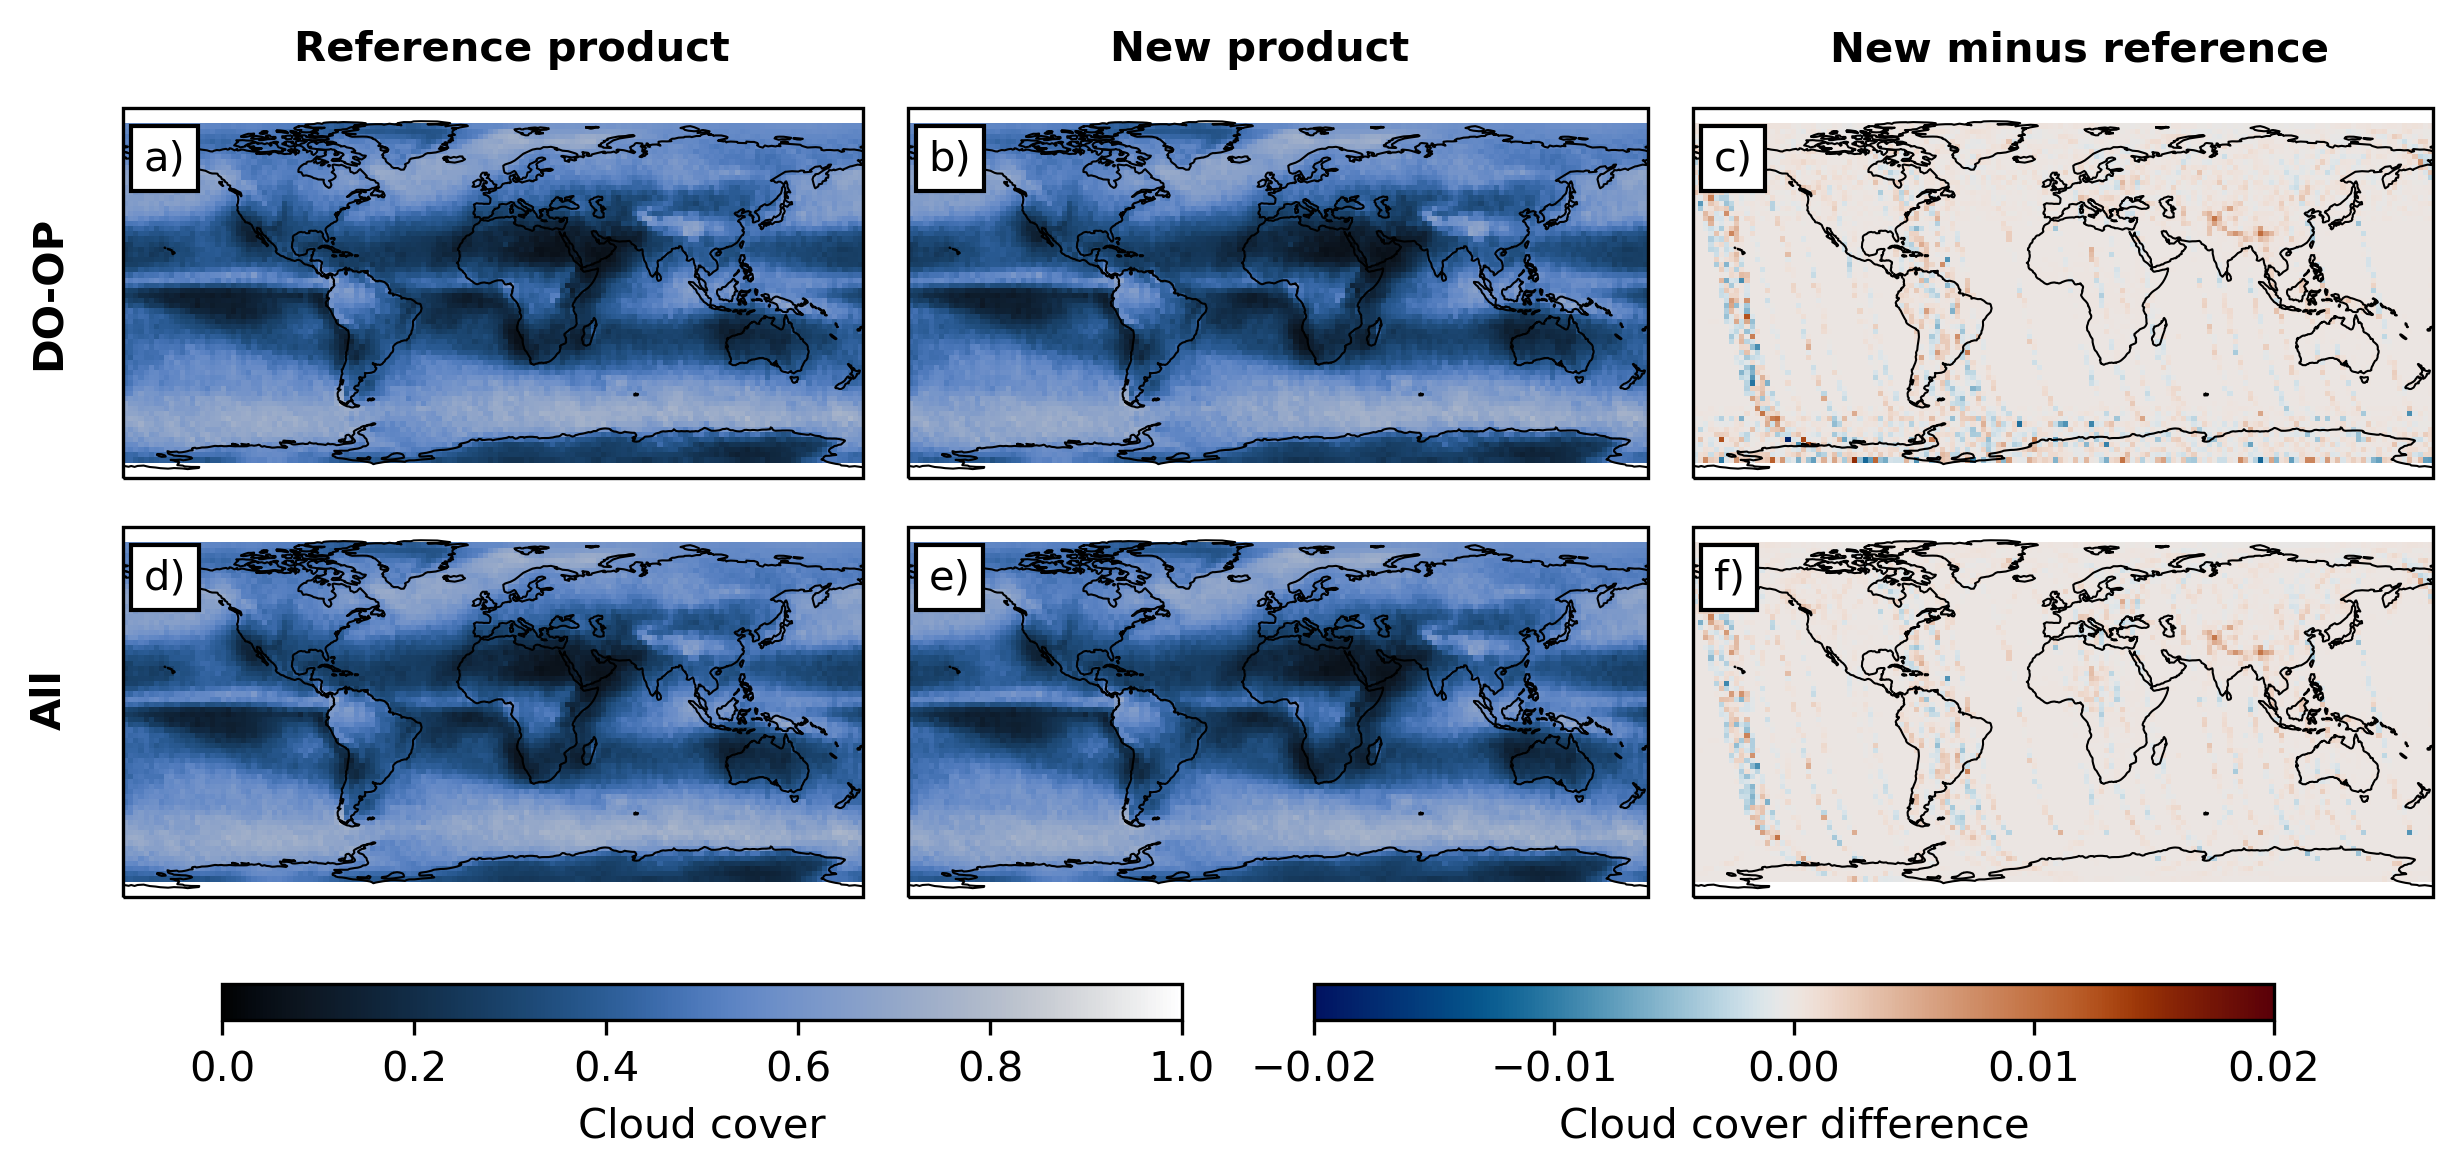

In [24]:
don = lambda ds: ds.sel(doop=1).total_cf
doff = lambda ds: ds.sel(doop=0).total_cf
dbot = lambda ds: ds.cloud_counts.sum(dim='doop')/ds.total_counts.sum(dim='doop')

cmap = cmc.cork

fig,axes = plt.subplots(2,3,subplot_kw={'projection':ccrs.PlateCarree()},figsize=(8,4),dpi=300,edgecolor='k')
texts = np.array([f'{s})' for s in 'abcdef']).reshape(axes.shape)
ims = np.zeros_like(axes,dtype=object)

doop_name = [b'DO-OP observable',b'All cases']
kind = ['3S-RMCP','wb-R05']
ds = xr.open_dataset('./essd_figs_files/9-4-1_3s-rmcp_3gc-ro2_comparison_bytime.nc')
data = [ds['3s-rmcp_cc'], ds['3gc-ro2_cc']]
data.append((data[1]-data[0]))
data = [ds.mean(dim='time') for ds in data]

for i,row in enumerate(axes):
    for j,ax in enumerate(row):
        if ax == row[-1]:
            diff  = (data[2]).sel(doop=doop_name[i])
            cmap  = cmc.vik
            vminx = np.nanmax(np.abs(diff.data))
            print('diff vminx: ',end='')
            print(vminx)
            vminx = 0.02
            vmin, vmax = -vminx, vminx
            #print(vminx.compute())
        else:
            diff  = data[j].sel(doop=doop_name[i])
            cmap  = cmc.oslo
            vminx = np.nanmax(np.abs(diff.data))
            print('climo vminx: ',end='')
            print(vminx)
            vmin, vmax = 0,1.0
        im = ax.imshow(diff, origin='lower', extent=[-180,180,-90,90], 
                                   transform=ccrs.PlateCarree(),cmap=cmap,interpolation='none',vmin=vmin,vmax=vmax,rasterized=True)
        ims[i][j] = im
        ax.text(-170,60, texts[i][j], #style='bold',
            bbox={'facecolor': 'white', 'alpha': 1, 'pad': 3})
        ax.add_feature(cf.COASTLINE,lw=0.5)
        
fig.tight_layout()
fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.06, 0.15, 0.4, 0.03])
cb = fig.colorbar(ims[0][0], cax=cbar_ax,orientation='horizontal')
cb.set_label('Cloud cover')
cbar_ax = fig.add_axes([0.515, 0.15, 0.4, 0.03])
cb = fig.colorbar(ims[0][-1], cax=cbar_ax,orientation='horizontal')
cb.set_label('Cloud cover difference')
fig.text(-0.02, 0.7, 
         'DO-OP', 
         weight = 'bold',
         fontsize = 'medium',
         rotation = 'vertical')
fig.text(-0.02, 0.4, 
         'All', 
         weight = 'bold',
         fontsize = 'medium',
         rotation = 'vertical')
fig.text(0.09, 0.95, 
         'Reference product', 
         weight = 'bold',
         fontsize = 'medium')
fig.text(0.43, 0.95, 
         'New product', 
         weight = 'bold',
         fontsize = 'medium')
fig.text(0.73, 0.95, 
         'New minus reference', 
         weight = 'bold',
         fontsize = 'medium')
fig.savefig('draft3_fig10_cloudcover_jun20.pdf',bbox_inches='tight',facecolor='white',transparent=False)

# fig. 9: validation against in-house CloudSat and CALIPSO L3

In [2]:
#open comparisons between 3gc-lo/ro2 and the two sister datasets
rmcp_gcro = xr.open_dataset('./essd_figs_files/9-4-1_3s-rmcp_3gc-ro2_comparison_bytime.nc')
cal3d_gclo = xr.open_dataset('./essd_figs_files/9-4-1_cal3d_3gc-lo_comparison_bytime.nc')

#remove cloud cover variables (handled in a separate figure)
rmcp_gcro = rmcp_gcro.drop_vars(['3gc-ro2_cc','3s-rmcp_cc'])

#join the two together into a single dict (can't do Dataset because coords are different)
results2 = { }
for varname in rmcp_gcro:
    results2[varname] = rmcp_gcro[varname]
for varname in cal3d_gclo:
    results2[varname] = cal3d_gclo[varname]

In [131]:
cal3d_gclo.height.diff(dim='height')

<xarray.DataArray 'height' (height: 75)>
array([-0.23961449, -0.23961639, -0.23961449, -0.23961639, -0.23961449,
       -0.23961449, -0.23961639, -0.23961544, -0.23961544, -0.23961544,
       -0.23961449, -0.23961639, -0.23961353, -0.23961639, -0.23961544,
       -0.23961544, -0.23961544, -0.23961449, -0.23961639, -0.23961544,
       -0.23961449, -0.23961544, -0.23961544, -0.23961544, -0.23961449,
       -0.23961639, -0.23961544, -0.23961449, -0.23961544, -0.23961544,
       -0.23961544, -0.23961544, -0.23961544, -0.23961544, -0.23961449,
       -0.23961639, -0.23961449, -0.23961544, -0.23961544, -0.23961544,
       -0.23961544, -0.23961544, -0.23961496, -0.23961592, -0.23961449,
       -0.23961544, -0.23961544, -0.23961496, -0.23961592, -0.23961496,
       -0.23961592, -0.23961496, -0.23961496, -0.23961544, -0.23961544,
       -0.23961544, -0.23961496, -0.23961568, -0.2396152 , -0.23961544,
       -0.23961544, -0.2396152 , -0.2396152 , -0.23961544, -0.23961544,
       -0.2396152 , -0.2396152 , -0.23961532, -0.23961544, -0.2396152 ,
       -0.23961532, -0.23961532, -0.23961538, -0.23961532, -0.23961532])
Coordinates:
  * height             (height) float64 17.62 17.38 17.14 ... 0.1291 -0.1105
    doop               |S16 b'All cases'
    Altitude_Midpoint  (height) float32 17.62 17.38 17.14 ... 0.1291 -0.1105

<xarray.DataArray 'cal3d_cfzm' ()>
array(0.45524889)
Coordinates:
    doop     |S16 b'All cases'
<xarray.DataArray '3gc-lo_cfzm' ()>
array(0.4522036)
Coordinates:
    doop     |S16 b'All cases'
<xarray.DataArray ()>
array(0.11427391)
Coordinates:
    doop     |S16 b'All cases'
<xarray.DataArray 'cal3d_afzm' ()>
array(0.64643572)
Coordinates:
    doop     |S16 b'All cases'
<xarray.DataArray '3gc-lo_afzm' ()>
array(0.44791346)
Coordinates:
    doop     |S16 b'All cases'
<xarray.DataArray ()>
array(0.06278074)
Coordinates:
    doop     |S16 b'All cases'
<xarray.DataArray '3s-rmcp_cfzm' ()>
array(0.50942832)
Coordinates:
    type     object ...
<xarray.DataArray '3gc-ro2_cfzm' ()>
array(0.50384579)
Coordinates:
    type     object ...
<xarray.DataArray ()>
array(0.03182892)
Coordinates:
    type     <U3 'any'


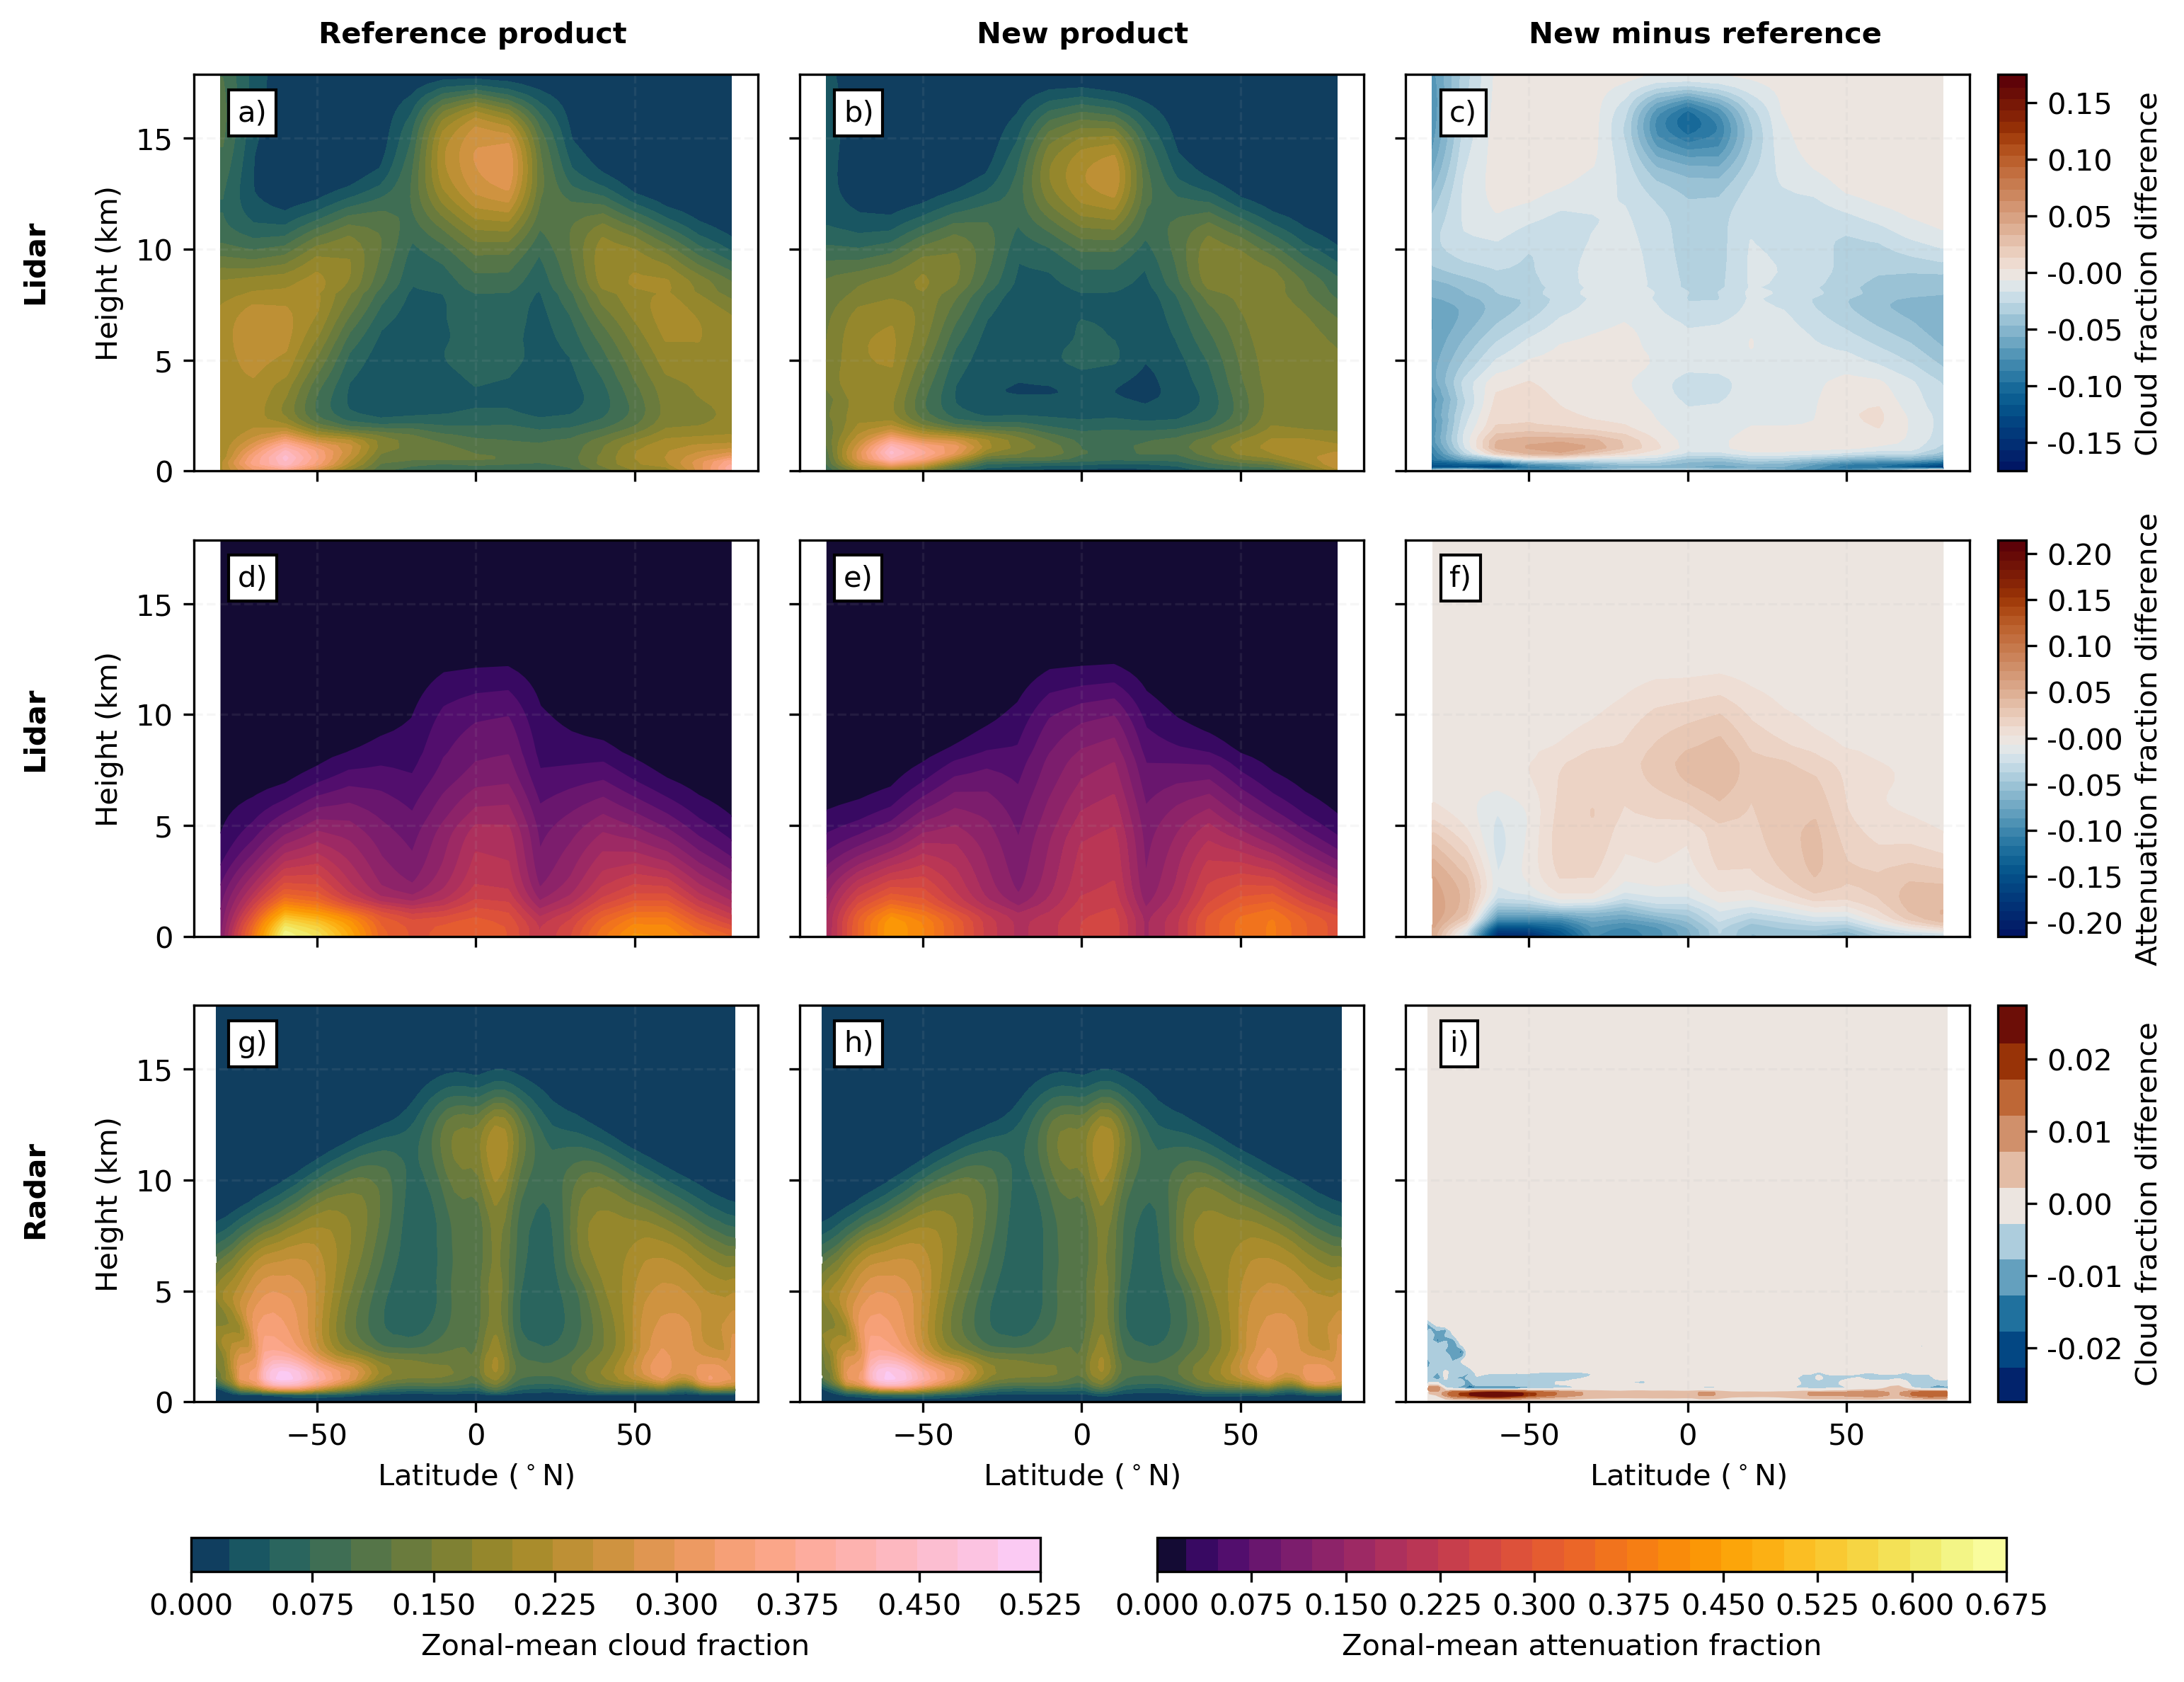

In [129]:
fig,axes = plt.subplots(3,3,figsize=(10,8),sharex=True,sharey=True,dpi=300)


#build nested list with the data array to plot at each point
comp_keys = [['cal3d_cfzm','3gc-lo_cfzm'],['cal3d_afzm','3gc-lo_afzm'],['3s-rmcp_cfzm','3gc-ro2_cfzm']] #input data keys to plot
data = [[results2[a],results2[b],results2[b]-results2[a]] for a,b in comp_keys] #build rows of A,B,B-A; A: ref, B: curr
data = [[ds.mean(dim='time') for ds in l] for l in data] #data have dimension of month, so take the mean over all months
data[2][1][69,:] = np.nan #mask 3GC-RO2 very low counts column at 85 N


ims = np.zeros_like(axes,dtype=object)
cblabels = ('Cloud fraction difference','Attenuation fraction difference', 'Cloud fraction difference')
texts = np.array([f'{s})' for s in 'abcdefghi']).reshape((3,3)) #grid of labels
dlvls = [np.arange(-0.18,0.18,0.02)+0.01,np.arange(-0.22,0.22,0.02)+0.01,np.arange(-0.5,0.5,0.02)+0.01]
dlvls = [np.arange(-0.18,0.18,0.01)+0.005,np.arange(-0.22,0.22,0.01)+0.005,np.arange(-0.03,0.03,0.005)+0.0025]
dticks = [np.arange(-0.2,0.25,0.05),np.arange(-0.2,0.25,0.05),np.arange(-0.03,0.04,0.01)]

#iterate over data-axis pairs and plot
i=0
for das, row in zip(data, axes):
    j=0
    for da, ax in zip(das,row):
        #difference plot options
        if ax==row[-1]:
            cmap = cmc.vik
            absmax = np.nanmax(np.abs(da.data))
            lvls = dlvls[i]
            inorm = mcolors.CenteredNorm()
        #state plot options
        elif ax in axes[1][:]:
            cmap = 'inferno'
            lvls = np.arange(0,0.7,0.025)
            inorm = norm(0,lvls[-1]) #power-law map from other figs
        else:
            cmap = cmc.batlow
            lvls = np.arange(0,0.55,0.025)
            inorm = norm(0,lvls[-1]) #power-law map from other figs
            
        print(da.max())
        im = ax.contourf(da.lat,da.height,da.T,cmap=cmap,levels=lvls,norm=inorm)
        for c in im.collections: #fix PDF white line aliasing in PDF
            c.set_edgecolor("face")
        ims[i][j] = im
        ax.grid(which='both',ls='--',alpha=0.1)
        ax.text(-75,15.8, texts[i][j], #style='bold',
        bbox={'facecolor': 'white', 'alpha': 1, 'pad': 3})
        
        #add colorbar to all difference plots
        if ax==row[-1]: 
            cb=fig.colorbar(im, ax=ax, cax=ax.inset_axes([1.05,0, 0.05, 1]),label=cblabels[i],ticks=dticks[i],format="%0.2f")
            cb.solids.set_edgecolor("face") #get rid of white lines between levels in PDF

        if ax in axes.T[0][:]:  ax.set_ylabel('Height (km)')
        if ax in axes[-1][:]: ax.set_xlabel(r'Latitude ($^\circ$N)')
        j+=1
    i+=1
axes[0][0].set_ylim(ymin=0)
fig.tight_layout()
fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.06, 0.1, 0.4, 0.02])
cb = fig.colorbar(ims[0][0], cax=cbar_ax,orientation='horizontal')
cb.solids.set_edgecolor("face") #get rid of white lines between levels in PDF

cb.set_label('Zonal-mean cloud fraction')
cbar_ax = fig.add_axes([0.515, 0.1, 0.4, 0.02])
cb = fig.colorbar(ims[1][0], cax=cbar_ax,orientation='horizontal')
cb.solids.set_edgecolor("face") #get rid of white lines between levels in PDF

cb.set_label('Zonal-mean attenuation fraction')
fig.text(-0.02, 0.85, 
         'Lidar', 
         weight = 'bold',
         fontsize = 'medium',
         rotation = 'vertical')
fig.text(-0.02, 0.575, 
         'Lidar', 
         weight = 'bold',
         fontsize = 'medium',
         rotation = 'vertical')
fig.text(-0.02, 0.3, 
         'Radar', 
         weight = 'bold',
         fontsize = 'medium',
         rotation = 'vertical')
fig.text(0.12, 1, 
         'Reference product', 
         weight = 'bold',
         fontsize = 'medium')
fig.text(0.43, 1, 
         'New product', 
         weight = 'bold',
         fontsize = 'medium')
fig.text(0.69, 1, 
         'New minus reference', 
         weight = 'bold',
         fontsize = 'medium')
fig.savefig('draft3_fig9a-i_cloudfraction_jun20_newht_newcolor.pdf',bbox_inches='tight',facecolor='white',transparent=False)

# fig 10: ARM NSA comparison

In [110]:
def draw_box(extent,transform=ccrs.Geodetic(),line_kws={'c':'b'},ax=ax,label=None):
    '''Draws a box on an axes along extent with a given transform. For indicating the
    extent of grid boxes on a map.'''
    lon_min, lat_min, lon_max, lat_max = extent
    #left, bottom, right, top
    ax.plot((lon_min,lon_max),(lat_min,lat_min),transform=geo,label=label,**line_kws) #top
    ax.plot((lon_min,lon_max),(lat_max,lat_max),transform=geo,**line_kws) #bot
    ax.plot((lon_min,lon_min),(lat_min,lat_max),transform=geo,**line_kws) #left
    ax.plot((lon_max,lon_max),(lat_min,lat_max),transform=geo,**line_kws) #right

def getmonthname(x,fmt='%B'):
    '''Returns month name from an int. 
    fmt specifies abbreviated ('%b') or full ('%B') name.'''
    return datetime.strptime(f'{x:02d}','%m').strftime(fmt)

In [111]:
pos_nsa = [-156.615,71.323] #NSA C1 lon,lat
pos_oli = [-149.886,70.495] #OLI M1 lon,lat

In [112]:
#load preprocessed data
cscal_t  = xr.open_dataset('./essd_figs_files/8-9-2_3gc_nsa_columns.nc')
ground_t = xr.open_dataset('./essd_figs_files/8-9-2_arm_nsa_ground_data.nc')

#2006/06-2006/12 comparison are outliers compared to the ensuing ten years
#not sure if the issue arises from ARM or CSCAL, but excluding for now
ground_t, cscal_t = ground_t.sel(time=slice('2007-01-01',None)), cscal_t.sel(time=slice('2007-01-01',None))

#take monthly means
ground, cscal = ground_t.groupby('time.month').mean(), cscal_t.groupby('time.month').mean()

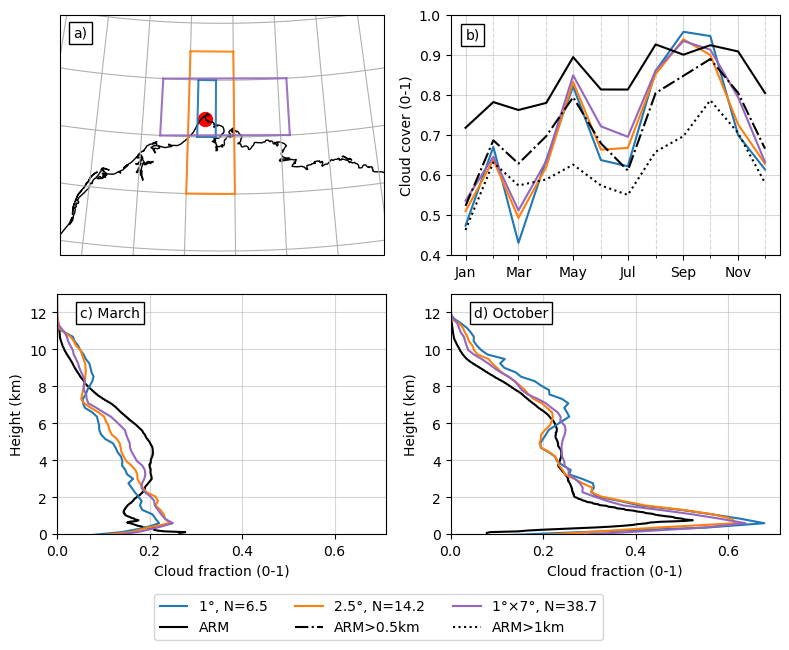

In [113]:
### DECLARE FIGURE ###
nrow,ncol = 2,2
fig  = plt.figure(figsize=(8,6),dpi=100)
gs   = fig.add_gridspec(nrow, ncol)

# calculate projection
extent = [-163.54, -147.81, 68.74, 73]
lon_min,lon_max,lat_min,lat_max = extent
central_lon, central_lat = 0.5*(extent[0]+extent[1]), 0.5*(extent[2]+extent[3])
crs = ccrs.Orthographic(central_longitude=central_lon, central_latitude=central_lat) #for gridbox map
geo = ccrs.Geodetic()

# declare axes
#first axis (0,0) has a projection, the others don't
axes = [[fig.add_subplot(gs[i,j],projection=crs) if i==0 and j==0 else fig.add_subplot(gs[i,j]) 
         for j in range(ncol)] for i in range(nrow)]

### PLOT SETTINGS ###
colors=('tab:blue','tab:orange','tab:green','tab:red','tab:brown','tab:purple','tab:grey','tab:pink') #colors for resolutions
keep_keys = ['1.0','2.5','1x7'] #resolutions to keep
res_map = {'1x7':'1°×7°','1x3':'1°×3°','1x5':'1°×5°','1.0':'1°','2.5':'2.5°','5.0':'5°'} #formatted resolutions
res_n = cscal_t.n_overpasses.mean(dim='time').sel(doop=b'All cases') #mean overpasses/month

### MAP SUBPLOT ###
ax = axes[0][0]
ax.set_extent(extent)
ax.gridlines()
ax.coastlines(resolution='10m')
ax.scatter(*pos_nsa,marker='o',s=100,c='r',transform=geo) #ground site marker
#ax.scatter(*pos_oli,marker='x',s=100,c='r',transform=geo) #alt site
#plot gridbox extents
for c,res in zip(colors,list(cscal.res.values)):
    ds = cscal.sel(res=res)
    if res not in keep_keys: continue
    col = ds.sel(doop=b'All cases')
    n = cscal_t.n_overpasses.sel(res=res).mean(dim='time').sel(doop=b'All cases').values
    box_extent = ds.gridbox_extent.mean(dim='month').values
    label = f'{res}°, N={n:.1f}' if res != '1x7' else f'1°×7°, N={n:.1f}'
    draw_box(box_extent,ax=ax,label=label,line_kws={'c':c,'alpha':0.9},transform=geo)
#ax.legend()
#ax.set_title('Gridboxes containing ARM NSA and predoop n_overpasses')
ax.text(-2.9e5,2.1e5, 'a)', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 3})

### MONTHLY CLOUD COVER ###
ax=axes[0][1]
#convert integer month to Pandas datetime
time=[pd.to_datetime(datetime.strptime(f'{mon:02d}','%m')) for mon in ground.month.values]
for res,color in zip(list(cscal.res.values),colors):
    if res not in keep_keys: continue
    ax.plot(time,cscal.sel(res=res).sel(doop=b'All cases').cloud_occurrence_in_column,
            label=f'{res_map[str(res)]}, N={float(res_n.sel(res=res)):.1f}',
            color=color)
    
#arm cloud cover above heights
for var,ls in zip(['tot_cld','tot_cld>0.5km','tot_cld>1km'],('-','-.',':')):
    ax.plot(time,ground[var],label='ARM'+var[7:],ls=ls,c='k')
ax.grid(axis='y')
#ax.legend(loc=(0.25,0.05),ncol=3)
#plt.title('2010 ARM NSA Comparison to L3-CSCAL (lat-1)')
ax.set_ylabel('Cloud cover (0-1)')
#plt.text(pd.to_datetime('2010-01-01'),0.95, 'b)', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 3})
ax.set_ylim(0.4,1.0)
ax.grid(which='major',alpha=0.5)
ax.grid(which='minor',alpha=0.5,ls='--')
ax.text(pd.to_datetime('1900-01-01'),0.94,'b)', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 3})
ax.xaxis.set_major_locator(mdates.MonthLocator(range(1,13,2)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())

### VERTICAL CLOUD FRACTION FOR TWO MONTHS ###
axes_i = axes[1][:] #second row
months = 3,10
titles = [f"{letter}) {getmonthname(mon,fmt='%B')}" for letter,mon in zip('cd',months)] #get titles of e.g. "d) October"
for ax,mon,title,xpos in zip(axes_i,months,titles,[0.05,0.05]):
    ground_i, cscal_i = ground.sel(month=mon), cscal.sel(month=mon).sel(doop=b'All cases')
    ax.plot(0.01*ground_i.cld_frac,ground_i.height/1e3,c='k')
    for res,color in zip(list(cscal_i.res.values),colors):
        if res not in keep_keys: continue
        ax.plot(cscal_i.cloud_occurrence_on_levels.sel(res=res),cscal_i.height/1e3,c=color,label=res_map[res])
    ax.set_ylim(0,12)
    ax.set_xlim(xmin=0)
    #ax.axhline(0.5,ls='--',c='k',lw=0.5)
    #ax.legend()
    ax.set_xlabel('Cloud fraction (0-1)')
    ax.set_ylabel('Height (km)')
    ax.set_ylim(0,13)
    ax.text(xpos,11.75,title, bbox={'facecolor': 'white', 'alpha': 1, 'pad': 3})
    ax.grid(which='major',alpha=0.5)
    ax.grid(which='minor',alpha=0.5,ls='--')
fig.tight_layout()
axes[1][0].set_xlim(axes[1][1].get_xlim()) #sharex

### ADD LEGEND ###
fig.subplots_adjust(bottom=0.1)
ax = axes[0][1] #use cloud cover lines to get the labels

#reorder handle order in legend
#put CSCAL in first row and ARM in second row
handles, labels = ax.get_legend_handles_labels()
order = [0,3,1,4,2,5] 
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
          loc=(-0.9,-1.6),fancybox=True, shadow=False,ncol=3)
fig.savefig('8-9-3_3gc_armnsa_comparison_jun20.pdf',facecolor='white',transparent=False,bbox_inches='tight')